<div style="border:solid orange 3px; padding: 16px">  
    <font size="4">  
        <p style="text-align: center;">
            <b> 8. Принятие решений в бизнесе на основе данных. Анализ результатов A/B-теста </b>
        </p> 
    </font>
</div>

<a id="contents"></a>
## Оглавление:
0. [Описание проекта](#0)
1. [Приоритизация гипотез](#1)
2. [Анализ результатов А/B-теста](#2)
    1. [2.1 Предобработка таблицы заказов](#2.1)
    1. [2.2 Предобработка таблицы посещений](#2.2)   
    1. [2.3 Расчет выручки](#2.3) 
    1. [2.4 Расчет конверсии](#2.4) 
    1. [2.5 Определение аномальных значений](#2.5)
    1. [2.6 Расчет статистической значимости различий по "сырым" данным](#2.6) 
    1. [2.7 Расчет статистической значимости различий по "очищенным" данным](#2.7)  
3. [Выводы](#3)

 <a id="0"></a>
## 0. Описание проекта
Данные - результат А/B-теста, информация о совершенных в интернет-магазине заказах с разделением на две группы. Также есть таблица с параметрами гипотез (охват, влияние на пользователей, уверенность в оценке параметров, затраты ресурсов),

Необходимо приоритизировать гипотезы по фреймворку ICE и RICE, а затем провести анализ результатов A/B-теста и сделать вывод о его успешности.

<a id="1"></a> 
## 1. Приоритизация гипотез [*(Оглавление)*](#contents)
Выберем наиболее важные гипотезы, используя два фреймворка. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

path = 'C:/Users/pavel/Desktop/da/projects/datasets/'

In [2]:
# таблица hypothesis (9 гипотез по увеличению выручки интернет-магазина с указанными параметрами)
hypothesis = pd.read_csv(path + '08_ab_hypothesis.csv')
hypothesis.style.set_properties(subset = 'Hypothesis', 
                                **{'width' : '690px', 'text-align' : 'left'})

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Описание данных:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в оценке других параметров гипотезы по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Таблица с характеристиками гипотез не содержит дубликатов и пропусков, а данные приведены к нужным типам.

In [4]:
# рассчитаем значение приоритета по фреймворку ICE (Impact - Confidence - Efforts)
hypothesis['ICE'] = ((hypothesis['Impact'] * hypothesis['Confidence'])/ hypothesis['Efforts']).round(2)

# добавим порядковый номер гипотезы при сортировке по уменьшению приоритета, фреймворк ICE
hypothesis['n_ICE'] = hypothesis['ICE'].rank(method = 'first', ascending = False)

# отсортируем по убыванию приоритета, фреймворк ICE                                                            
hypothesis[['Hypothesis', 'ICE', 'n_ICE']]\
        .sort_values(by = 'ICE', ascending = False)\
        .style.set_properties(subset = 'Hypothesis', 
                              **{'width' : '690px', 'text-align' : 'left'})

,Hypothesis,ICE,n_ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,1
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,2
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,4
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,5
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,6
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,7
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,9


In [5]:
# рассчитаем значение приоритета по фреймворку RICE (Reach - Impact - Confidence - Efforts)
hypothesis['RICE'] = ((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'])/ hypothesis['Efforts'])\
                     .round(2)

# добавим порядковый номер гипотезы при сортировке по уменьшению приоритета, фреймворк RICE
hypothesis['n_RICE'] = hypothesis['RICE'].rank(method = 'first', ascending = False)

# отсортируем по убыванию приоритета, фреймворк RICE                                                            
hypothesis[['Hypothesis', 'RICE', 'n_RICE', 'n_ICE', 'ICE']]\
    .sort_values(by = 'RICE', ascending = False)\
    .style.set_properties(subset = 'Hypothesis', 
                          **{'width' : '690px', 'text-align' : 'left'})\
    .background_gradient(cmap = 'Blues_r', subset = 'n_RICE')\
    .background_gradient(cmap = 'Blues_r', subset = 'n_ICE')

,Hypothesis,RICE,n_RICE,n_ICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112,1,3,11.2
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56,2,5,7
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40,3,2,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40,4,4,8
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,5,1,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9,6,8,1.12
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4,7,6,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4,8,7,1.33
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,9,9,1


При изменении фреймворка с ICE на RICE, более высокий приоритет получили гипотезы 7 и 2 из-за их высокого относительного значения параметра Reach (охват пользователей).

Первые 5 гипотез по обоим фреймворкам совпадают.

<a id="2"></a>
## 2. Анализ результатов A/B-теста  [*(Оглавление)*](#contents)

<a id="2.1"></a>
### 2.1 Предобработка таблицы заказов  [*(Оглавление)*](#contents)

In [6]:
# таблица orders (информация о заказах)
orders = pd.read_csv(path + '08_ab_orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Описание данных:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата совершения заказа;
- `revenue` — выручка от заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Проведем предобработку данных.

In [7]:
# переименуем столбцы
orders = orders.rename(columns = {"transactionId" : "transaction_id", 
                                  "visitorId" : "visitor_id"})

In [8]:
# выведем общую информацию о таблице
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null object
revenue           1197 non-null int64
group             1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Пропусков в данных нет.

In [9]:
# приведем данные о дате заказа к типу даты
orders['date'] =  pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [10]:
# количество полных дубликатов
orders.duplicated().sum()

0

Отсутствуют полные дубликаты.

Рассмотрим подробнее данные в отдельных столбцах.

In [11]:
# количество дубликатов в столбце с номером заказа
orders['transaction_id'].duplicated().sum()

0

Нет дубликатов в столбце `transaction_id`, все транзакции уникальные.

In [12]:
# распределение дат заказов
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

В таблице содержится информация о заказах, совершенных с 1 по 31 августа 2019 года.

In [13]:
# распределение выручки
orders['revenue'].describe().round(1)

count       1197.0
mean        8348.0
std        39191.1
min           50.0
25%         1220.0
50%         2978.0
75%         8290.0
max      1294500.0
Name: revenue, dtype: float64

Отсутствуют отрицательные значения.

In [14]:
# уникальные значения групп и количество заказов в этих группах
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

Всего 2 группы, как и должно быть в A/B-тесте. Количество заказов в группах отличается на 15%.

<a id="2.2"></a>
### 2.2 Предобработка таблицы посещений  [*(Оглавление)*](#contents)

In [15]:
# таблица visitors (информация о посещениях)
visitors = pd.read_csv(path + '08_ab_visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Описание данных:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество посетителей в указанную дату в указанной группе A/B-теста

Проведем предобработку данных.

In [16]:
# выведем общую информацию о таблице
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков в данных нет.

In [17]:
# приведем данные о дате посещения к типу даты
visitors['date'] =  pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [18]:
# количество дубликатов
visitors.duplicated().sum()

0

Отсутствуют полные дубликаты.

Рассмотрим подробнее данные в отдельных столбцах.

In [19]:
# распределение дат посещений
visitors['date'].describe()

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

В таблице содержится информация о посещениях, совершенных с 1 по 31 августа 2019 года. Такой же временной интервал, как и в таблице с заказами.

In [20]:
# распределение количества посетителей
visitors['visitors'].describe().round(1)

count     62.0
mean     607.3
std      114.4
min      361.0
25%      534.0
50%      624.5
75%      710.5
max      770.0
Name: visitors, dtype: float64

Отсутствуют отрицательные значения.

In [21]:
# уникальные значения групп 
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

Всего 2 группы, как и должно быть в A/B-тесте. Для обеих групп указано количество посетителей в каждый день.

<a id="2.3"></a>
### 2.3 Расчет выручки   [*(Оглавление)*](#contents)
Для каждой группы рассчитаем кумулятивную выручку, кумулятивный средний чек и его относительное изменение. 

In [22]:
# создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

In [23]:
dates_groups.head(3)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A


Рассчитаем кумулятивные характеристики: сумму выручки, число уникальных заказов, число уникальных пользователей так, чтобы для каждой даты были учтены заказы от начала теста до этой даты.

In [24]:
# применим lambda-функцию к каждой строке датасета dates_groups
# из таблицы с заказами выберем те, дата которых меньше или равна дате элемента из dates_groups, 
# а группа теста равна группе из dates_groups
orders_aggregated = (dates_groups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                          orders['group'] == x['group'])]
    .agg({'date' : 'max', # самая поздняя дата
          'group' : 'max', # указание группы
          'transaction_id' : pd.Series.nunique, # количество уникальных заказов
          'visitor_id' : pd.Series.nunique, # количество уникальных посетителей
          'revenue' : 'sum'}), axis=1) # сумма выручки
    .sort_values(by=['date', 'group']))  # сортировка по дате и группе

orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Аналогично получим аггрегированные кумулятивные данные по дням о посещениях.

In [25]:
visitors_aggregated = (dates_groups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                             visitors['group'] == x['group'])]
    .agg({'date' : 'max', # самая поздняя дата
          'group' : 'max', # указание группы
          'visitors' : 'sum'}), axis=1) # сумма посетителей
    .sort_values(by=['date', 'group']))  # сортировка по дате и группе

visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим кумулятивные данные о заказах и посещениях по дате и группе.

In [26]:
cummulative_data = orders_aggregated.merge(visitors_aggregated, 
                                           left_on=['date', 'group'], 
                                           right_on=['date', 'group'])
# переименуем столбцы
cummulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cummulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


---

Выделим данные о выручке и количестве заказов по группам в разные датасеты.

In [27]:
# данные о дате, выручке, количестве заказов для группы А
cummulative_revenue_A = \
cummulative_data[cummulative_data['group']=='A'][['date', 'revenue', 'orders']]

# данные о дате, выручке, количестве заказов для группы B
cummulative_revenue_B = \
cummulative_data[cummulative_data['group']=='B'][['date', 'revenue', 'orders']]

Для анализа относительного различия в группах A и B, соединим данные в одном датасете.

In [28]:
# объединим по дате и добавим суффиксы
merged_cummulative_revenue = cummulative_revenue_A\
    .merge(cummulative_revenue_B, left_on='date', right_on='date', how='left', 
           suffixes=['_A', '_B'])

merged_cummulative_revenue.head()

,date,revenue_A,orders_A,revenue_B,orders_B
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


Построим графики кумулятивной выручки и кумулятивного среднего чека по группам, а также график относительного изменения кумулятивного среднего чека группы В к группе А.

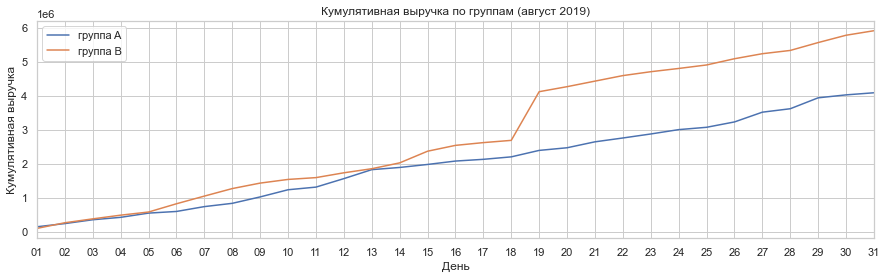

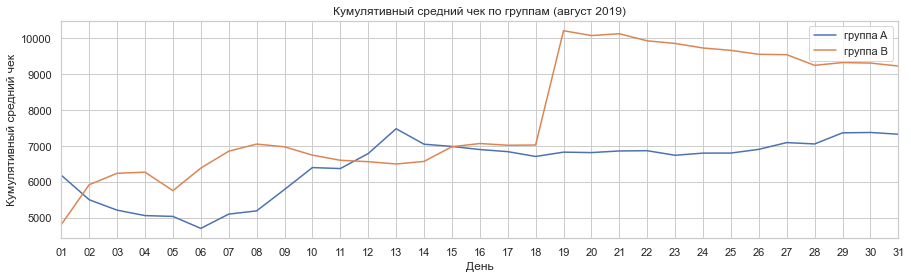

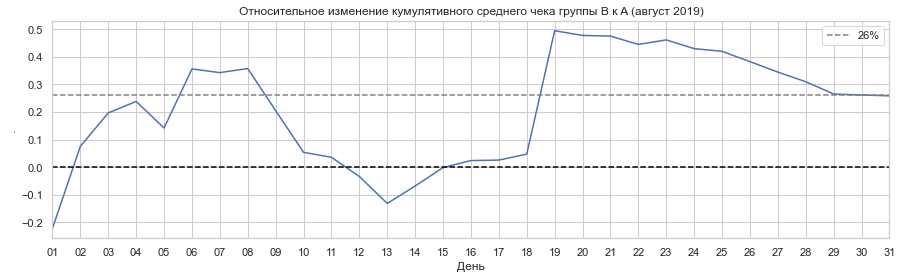

In [29]:
sns.set(style = 'whitegrid')
cummulative_revenue_A['plot_date'] = cummulative_revenue_A['date'].dt.strftime('%d')
cummulative_revenue_B['plot_date'] = cummulative_revenue_B['date'].dt.strftime('%d')

f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x = "plot_date", y = "revenue", data = cummulative_revenue_A, label = 'группа A')
sns.lineplot(x = "plot_date", y = "revenue", data = cummulative_revenue_B, label = 'группа B')
ax.set(xlabel = 'День', ylabel = 'Кумулятивная выручка',xlim = ('01', '31'),
       title = 'Кумулятивная выручка по группам (август 2019)')

# кумулятивный средний чек рассчитаем как отношение кумулятивной выручки к суммарному числу заказов
cummulative_revenue_A['average_revenue'] = cummulative_revenue_A['revenue']/ cummulative_revenue_A['orders']
cummulative_revenue_B['average_revenue'] = cummulative_revenue_B['revenue']/ cummulative_revenue_B['orders']

f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x = "plot_date", y = "average_revenue", data = cummulative_revenue_A, label = 'группа A')
sns.lineplot(x = "plot_date", y = "average_revenue", data = cummulative_revenue_B, label = 'группа B')
ax.set(xlabel = 'День', ylabel = 'Кумулятивный средний чек',xlim = ('01', '31'),
       title = 'Кумулятивный средний чек по группам (август 2019)')

# относительное изменение кумулятивного среднего чека рассчитаем как отношение кумулятивного среднего чека группы B
# к кумулятивному среднему чеку группы А, без единицы
merged_cummulative_revenue['plot_date'] = merged_cummulative_revenue['date'].dt.strftime('%d')
merged_cummulative_revenue['average_revenue_rate'] = (
(merged_cummulative_revenue['revenue_B']/merged_cummulative_revenue['orders_B'])/
(merged_cummulative_revenue['revenue_A']/merged_cummulative_revenue['orders_A'])-1)


f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x = "plot_date", y = "average_revenue_rate", data = merged_cummulative_revenue)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.26, color='gray', linestyle='--', label = '26%')
ax.set(xlabel = 'День', ylabel = '.',xlim = ('01', '31'),
       title = 'Относительное изменение кумулятивного среднего чека группы B к A (август 2019)')

plt.legend()
plt.show()

В течение всего рассматриваемого месяца кумулятивная выручка группы B превышает выручку группы А. Кумулятивный средний чек группы В больше в течение всего месяца за исключением первого дня теста и периода 11-14 августа. 

На графике кумулятивной выручки заметен скачок 18 августа, что может быть связано с резким увеличением количества или стоимости отдельных заказов. В то же время на графике кумулятивного среднего чека наблюдается такой же скачок, делаем вывод о наличии одного или нескольких крупных заказов в группе В.

На графике относительного изменения кумулятивного среднего чека видим несколько резких скачков, скорее всего это связано с наличием аномально крупных заказов. К концу месяца, кумулятивный средний чек группы B больше среднего чека группы А на 26%.

<a id="2.4"></a>
### 2.4 Расчет конверсии   [*(Оглавление)*](#contents)

Кумулятивную конверсию рассчитаем, как отношение количества заказов к количеству посетителей.

In [30]:
cummulative_data['conversion'] = (cummulative_data['orders']/ cummulative_data['visitors']).round(4)

In [31]:
cummulative_data.head(5)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.0334
1,2019-08-01,B,21,20,101217,713,0.0295
2,2019-08-02,A,44,38,242401,1338,0.0329
3,2019-08-02,B,45,43,266748,1294,0.0348
4,2019-08-03,A,68,62,354874,1845,0.0369


Выделим данные о конверсии по группам в разные датасеты.

In [32]:
# данные для группы А
cummulative_data_A = cummulative_data[cummulative_data['group']=='A']

# данные для группы B
cummulative_data_B = cummulative_data[cummulative_data['group']=='B']

cummulative_data_A.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.0334
2,2019-08-02,A,44,38,242401,1338,0.0329
4,2019-08-03,A,68,62,354874,1845,0.0369
6,2019-08-04,A,84,77,425699,2562,0.0328
8,2019-08-05,A,109,100,549917,3318,0.0329


Для анализа относительного различия в группах A и B, соединим данные в одном датасете.

In [33]:
# объединим по дате и добавим суффиксы
merged_cummulative_conversion = cummulative_data_A[['date', 'conversion']]\
    .merge(cummulative_data_B[['date', 'conversion']], left_on='date', 
           right_on='date', how='left', suffixes=['_A', '_B'])

merged_cummulative_conversion.head()

,date,conversion_A,conversion_B
0,2019-08-01,0.0334,0.0295
1,2019-08-02,0.0329,0.0348
2,2019-08-03,0.0369,0.0338
3,2019-08-04,0.0328,0.0303
4,2019-08-05,0.0329,0.0308


Построим графики кумулятивной конверсии по группам и график относительного изменения кумулятивной конверсии группы B к группе A.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


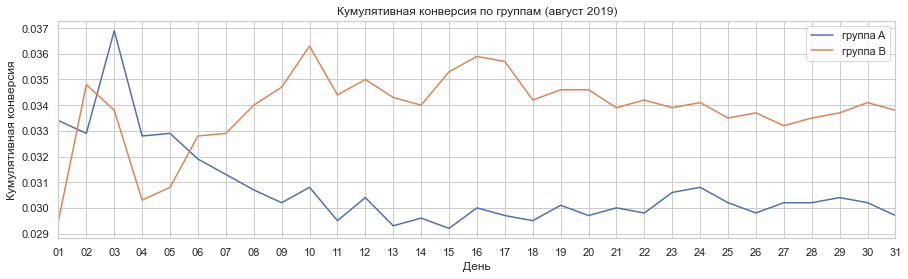

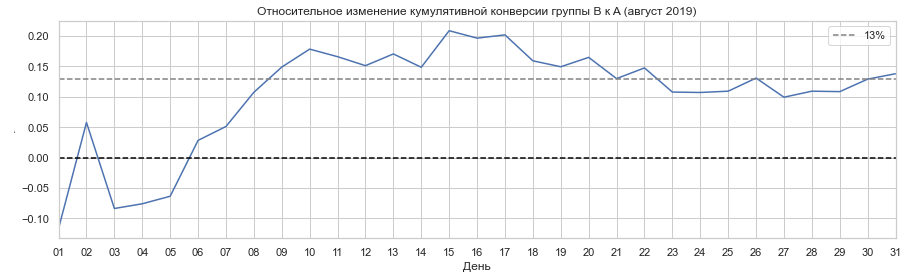

In [34]:
cummulative_data_A['plot_date'] = cummulative_data_A['date'].dt.strftime('%d')
cummulative_data_B['plot_date'] = cummulative_data_B['date'].dt.strftime('%d')
merged_cummulative_conversion['plot_date'] = merged_cummulative_conversion['date'].dt.strftime('%d')

f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x = "plot_date", y = "conversion", data = cummulative_data_A, label = 'группа A')
sns.lineplot(x = "plot_date", y = "conversion", data = cummulative_data_B, label = 'группа B')
ax.set(xlabel = 'День', ylabel = 'Кумулятивная конверсия',xlim = ('01', '31'),
       title = 'Кумулятивная конверсия по группам (август 2019)')

# относительное изменение кумулятивной конверсии рассчитаем как отношение кумулятивной конверсии группы B
# к кумулятивной конверсии группы А, без единицы
merged_cummulative_conversion['conversion_rate'] = (merged_cummulative_conversion['conversion_B']/
                                                    merged_cummulative_conversion['conversion_A']-1)


f, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(x = "plot_date", y = "conversion_rate", data = merged_cummulative_conversion)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.13, color='gray', linestyle='--', label = '13%')
ax.set(xlabel = 'День', ylabel = '.',xlim = ('01', '31'),
       title = 'Относительное изменение кумулятивной конверсии группы B к A (август 2019)')

plt.legend()
plt.show()

Конверсии установились после 9 августа, далее конверсия группы B была больше конверсии группы A. К окончанию теста это различие достигает 13%.

<a id="2.5"></a>
### 2.5 Определение аномальных значений [*(Оглавление)*](#contents)
Рассмотрим распределение количества заказов по пользователям, и стоимости заказов. Определим границу для аномальных значений. 

Построим точечный график количества заказов по пользователям, для этого сгруппируем таблицу с заказами по `visitor_id`.

In [35]:
orders_by_users = orders.groupby('visitor_id', as_index = False)\
                        .agg({'transaction_id':pd.Series.nunique})
orders_by_users.head()

,visitor_id,transaction_id
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


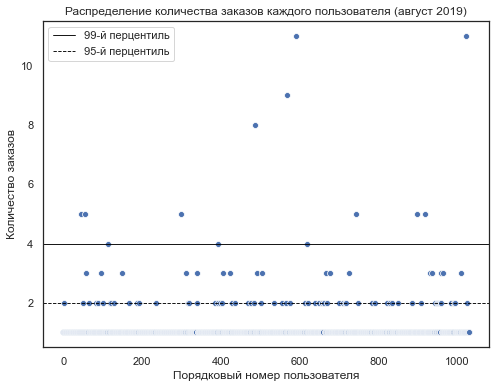

95-й перцентиль количества заказов на пользователя: 2.0
99-й перцентиль количества заказов на пользователя: 4.0


In [36]:
sns.set(style = 'white')

# создадим набор чисел от 0 до количества пользователей
x_values = pd.Series(range(0,len(orders_by_users['visitor_id'])))

# диаграмма распределения количества заказов по пользователям
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x = x_values, y = "transaction_id", data = orders_by_users)

ax.set(xlabel = 'Порядковый номер пользователя', ylabel = 'Количество заказов',
       title = 'Распределение количества заказов каждого пользователя (август 2019)')

plt.axhline(y=np.percentile(orders_by_users['transaction_id'], [95, 99])[1], 
            color='black', linestyle='-', linewidth = 0.9, label = '99-й перцентиль')
plt.axhline(y=np.percentile(orders_by_users['transaction_id'], [95, 99])[0], 
            color='black', linestyle='--', linewidth = 0.9, label = '95-й перцентиль')

plt.legend()
plt.show()

print('95-й перцентиль количества заказов на пользователя:', np.percentile(orders_by_users['transaction_id'], [95, 99])[0])
print('99-й перцентиль количества заказов на пользователя:', np.percentile(orders_by_users['transaction_id'], [95, 99])[1])

In [37]:
# количество пользователей, оформивших более 4 заказов
len(orders_by_users[orders_by_users['transaction_id'] > 4])

10

Всего 1% процент пользователей заказывают более 4 раз. Не будем учитывать таких пользователей из-за их малого количества.

---

Построим точечный график стоимости заказов.

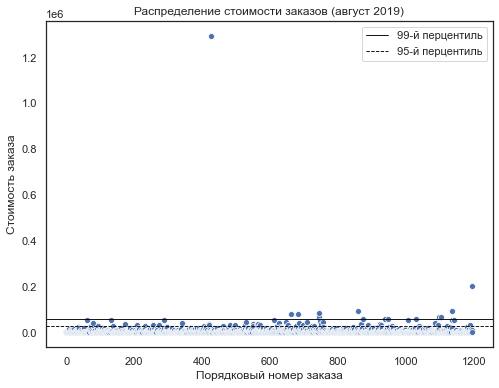

95-й перцентиль стоимости заказа: 28000.0
99-й перцентиль стоимости заказа: 58233.2


In [38]:
# создадим набор чисел от 0 до количества заказов
x_values = pd.Series(range(0,len(orders['transaction_id'])))

f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x = x_values, y = "revenue", data = orders)

ax.set(xlabel = 'Порядковый номер заказа', ylabel = 'Стоимость заказа',
       title = 'Распределение стоимости заказов (август 2019)')

plt.axhline(y=np.percentile(orders['revenue'], [95, 99])[1], 
            color='black', linestyle='-', linewidth = 0.9, label = '99-й перцентиль')
plt.axhline(y=np.percentile(orders['revenue'], [95, 99])[0], 
            color='black', linestyle='--', linewidth = 0.9, label = '95-й перцентиль')

plt.legend()
plt.show()

print('95-й перцентиль стоимости заказа:', np.percentile(orders['revenue'], [95, 99])[0].round(1))
print('99-й перцентиль стоимости заказа:', np.percentile(orders['revenue'], [95, 99])[1].round(1))

Будем считать аномальными заказы, стоимость которых больше 58233, т.к. количество таких заказов мало - всего 1% от общего числа.

In [39]:
# количество заказов стоимостью более 58.233
len(orders[orders['revenue'] > 58233])

12

<a id="2.6"></a>
### 2.6 Расчет статистической значимости различий по "сырым" данным  [*(Оглавление)*](#contents)

Для расчета статистической значимости различий в конверсии будем использовать критерий Манна-Уитни. Для этого для каждой группы подготовим список, где для каждого покупателя будет указано количество заказов, и для каждого посетителя, не оформившего заказа будет указан 0.

In [40]:
# выделим 2 датасета с количеством заказов каждого пользователя
orders_by_users_A = orders[orders['group'] == 'A'].groupby('visitor_id', as_index = False)\
                        .agg({'transaction_id': pd.Series.nunique})
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = orders[orders['group'] == 'B'].groupby('visitor_id', as_index = False)\
                        .agg({'transaction_id': pd.Series.nunique})
orders_by_users_B.columns = ['visitor_id', 'orders']

In [41]:
# для каждой группы создадим список из 2-х частей
sample_A = pd.concat([orders_by_users_A['orders'], # количество заказов для посетителей с заказами
                      pd.Series(0, index= np.arange # 0 для всех остальных посетителей в группе
                               (visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_A['orders'])),
                                name='orders')
                     ],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'], # количество заказов для посетителей с заказами
                      pd.Series(0, index= np.arange # 0 для всех остальных посетителей в группе
                               (visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_B['orders'])), 
                                name='orders')
                     ],axis=0)

Сформулируем нулевую гипотезу: конверсия группы A равна конверсии группы B (статистических различий в конверсии двух групп теста нет). Критический уровень статистической значимости примем равным 5%.

In [42]:
# для сравнения 2-х списков с количеством заказов для разных групп используем критерий Манна-Уитни
print('P-value:', stats.mannwhitneyu(sample_A, sample_B)[1].round(4))

P-value: 0.0084


P-value меньше критического значения, отвергаем нулевую гипотезу.

In [43]:
# поскольку количество элементов в списке - количество посетителей, 
# а сумма элементов - количество заказов, найдём относительный прирост конверсии группы B к А
'{:.3f}'.format(sample_B.mean()/sample_A.mean()-1)

'0.138'

В "сырых" данных конверсия группы B на 14% выше чем в группе A.

---

Сравним средние чеки заказов в разных группах. Сформулируем нулевую гипотезу: средний чек в группе А равен среднему чеку в группе В (статистических различий в среднем чеке для двух групп теста нет). Критический уровень статистической значимости примем равным 5%.

In [44]:
print('P-value:', stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                     orders[orders['group']=='B']['revenue'])[1].round(4))

P-value: 0.3646


P-value больше критического значения: нет оснований отвергать нулевую гипотезу, т.е. нет оснований считать, что средние чеки двух групп отличаются.

In [45]:
# относительные различия в среднем чеке группы B к А
'{:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/ 
orders[orders['group']=='A']['revenue'].mean() - 1)

'0.259'

Средний чек различается на 26%. Предположим, что статистической значимости различия нет из-за сильного рассеяния стоимости заказов внутри каждой группы.

<a id="2.7"></a>
### 2.7 Расчет статистической значимости различий по "очищенным" данным  [*(Оглавление)*](#contents)

Выделим пользователей с аномально большим количеством заказов и/ или с аномально большой стоимостью заказов в отдельный список. Затем исключим их из рассмотрения и проведем повторный расчет статистической значимости различий в конверсии и среднем чеке.

In [46]:
# аномальные пользователи: количество заказов > 4 и/или сумма заказа > 58.233
abnormal_visitors = pd.concat([orders_by_users_A[orders_by_users_A['orders'] > 4]['visitor_id'],
                               orders_by_users_B[orders_by_users_B['orders'] > 4]['visitor_id'],
                               orders[orders['revenue'] > 58233]['visitor_id']
                              ], axis = 0).drop_duplicates()

# количество аномальных пользователей
len(abnormal_visitors)

15

In [47]:
# повторим вычисления без учета аномальных пользователей
# для каждой группы создадим список из 2-х частей
sample_A_filtered = pd.concat(
# количество заказов для неаномальных посетителей с заказами    
[orders_by_users_A[np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_visitors))]['orders'], 
# 0 для всех остальных посетителей в группе (их количество не зависит от количества аномальных пользователей)
pd.Series(0, index= np.arange 
         (visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_A['orders'])), 
          name='orders')
                     ],axis=0)

sample_B_filtered = pd.concat(
# количество заказов для неаномальных посетителей с заказами    
[orders_by_users_B[np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_visitors))]['orders'], 
# 0 для всех остальных посетителей в группе (их количество не зависит от количества аномальных пользователей)
pd.Series(0, index= np.arange 
         (visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_B['orders'])), 
                                name='orders')
                     ],axis=0)

Сформулируем нулевую гипотезу: статистических различий в конверсии двух групп теста без учета аномальных пользователей нет. Критический уровень статистической значимости примем равным 5%.

In [48]:
# для сравнения 2-х списков с количеством заказов для разных групп используем критерий Манна-Уитни
print('P-value:', stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1].round(4))

P-value: 0.0072


P-value меньше критического значения, отвергаем нулевую гипотезу. Конверсии в двух группах не равны.

In [49]:
# поскольку количество элементов в списке - количество посетителей, 
# а сумма элементов - количество заказов, найдём относительный прирост конверсии группы B к А
'{:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1)

'0.153'

В "очищенных" данных конверсия группы B на 15% выше чем в группе A.

---

Сравним средние чеки заказов в разных группах. Сформулируем нулевую гипотезу: статистических различий в среднем чеке для двух групп теста без учета аномальных пользователей нет. Критический уровень статистической значимости примем равным 5%.

In [50]:
print('P-value:', stats.mannwhitneyu(
     orders[np.logical_and(orders['group']=='A',
                           np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue'],
     orders[np.logical_and(orders['group']=='B',
                           np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue']
                                    )[1].round(4))

P-value: 0.4255


P-value больше критического значения, нет оснований отвергать нулевую гипотезу, т.е. нет оснований считать средний чек различным.

In [51]:
# относительные различия в среднем чеке группы B к А
'{:.3f}'.format(orders[np.logical_and(orders['group']=='B',
                       np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue'].mean() / 
orders[np.logical_and(orders['group']=='A',
                      np.logical_not(orders['visitor_id'].isin(abnormal_visitors)))]['revenue'].mean() - 1)

'-0.006'

В "очищенных" данных средние чеки разных групп практически не различаются. Удаление аномальных пользователей не повлияло на статистическую значимость различий, но существенно повлияло на значение этих различий.

<a id="3"></a>
## 3. Выводы [*(Оглавление)*](#contents)

1. И в "сырых" и в "очищенных" данных достигается статистическая значимость различий в конверсии между двумя группами - конверсия в группе B больше на 14-15%.
2. И в "сырых" и в "очищенных" данных нет статистической значимости различий в среднем чеке между двумя группами. В первночальном расчете средний чек группы B был выше на 26%, а после удаления аномалий значения среднего чека для обеих групп сровнялись. 

Принимаем решение остановить тест, зафиксировав увеличение конверсии в группе B.